V přednášce jsme si předvedli jednoduchý genetický algoritmus. Dnes si ho zkusíme naprogramovat a vyřešit si pomocí něj dva jednoduché problémy - OneMAX a součet podmnožiny.

Nakonec si ještě ukážeme knihovnu `deap`, která se dá použít pro implementaci složitějších evolučních algoritmů.

Implemenace algoritmu je velmi jednoduchá, začneme tím, že si napíšeme jeho kostru (skoro jako pseudokód).

In [1]:
import numpy as np

def evoluce(pop_size, ind_size, max_gen, fitness, cx_pb = 0.8, mut_pb=0.1, per_bit_pb = 0.2):
    populace = nahodna_populace(pop_size, ind_size)
    log = []
    for i in range(max_gen):
        fit = list(map(fitness, populace))
        log.append(max(fit))
        mating_pool = selekce(populace, fit, pop_size)
        potomci = krizeni(mating_pool, cx_pb)
        potomci = mutace(potomci, mut_pb, per_bit_pb)
        populace = potomci[:] # shallow copy
    
    fit = list(map(fitness, populace))
    best = populace[np.argmax(fit)]
    return best, populace, log

Teď potřebujeme napsat implementace funkcí použitých výše. Začneme inicializací náhodné populace - budeme uvažovat pouze jedince, kteří jsou seznamy 1 a 0.

In [2]:
import random

def nahodna_populace(pop_size, ind_size):
    pop = []
    for _ in range(pop_size):
        ind = [0 if random.random() < 0.5 else 1 for _ in range(ind_size)]
        pop.append(ind)
    
    return pop

nahodna_populace(5, 10)

[[1, 0, 1, 1, 1, 1, 0, 0, 0, 1],
 [1, 1, 0, 0, 0, 1, 0, 1, 0, 0],
 [1, 0, 0, 0, 0, 1, 1, 0, 1, 0],
 [0, 0, 0, 0, 0, 0, 1, 1, 1, 1],
 [0, 0, 1, 1, 0, 1, 1, 1, 1, 1]]

Dále si naprogramujeme ruletovou selekci - to je jednoduché, modul random obsahuje funkci choices, která dělá přesně to, co potřebujeme.

In [3]:
import copy

def selekce(pop, fit, N):
    return copy.deepcopy(random.choices(pop, weights=fit, k=N)) # musime udelat hlubokou kopii

Teď uděláme ještě jednobodové křížení a mutaci, která změní náhodný bit. U obou operátorů čekáme, že dostaneme celou populaci.

In [4]:
def krizeni(pop, cx_pb = 0.8):
    new_pop = []
    for i in range(len(pop)//2):
        
        o1 = copy.deepcopy(pop[2*i])
        o2 = copy.deepcopy(pop[2*i + 1])
        
        if random.random() < cx_pb: # pravdepodobnost krizeni
            bod = random.randrange(0, len(o1))
            zacateko2 = o2[:bod]
            o2[:bod] = o1[:bod]
            o1[:bod] = zacateko2[:]
        
        new_pop.append(o1)
        new_pop.append(o2)
    
    return new_pop

def mutace(pop, mut_pb = 0.1, per_bit_pb = 0.2):
    new_pop = []
    for ind in pop:
        
        o = copy.deepcopy(ind)
        
        if random.random() < mut_pb: # pravdepodobnost mutace
            o = [1-x if random.random() < per_bit_pb else x for x in o] # pri mutaci zmenime bit na opacnou 
                                                                        # hodnotu s psti per_bit_pb
        
        new_pop.append(o)
    
    return new_pop

import pprint
pop = nahodna_populace(6, 10)
print('populace')
pprint.pprint(pop)
print('po krizeni')
pprint.pprint(krizeni(pop))
print('po mutaci')
pprint.pprint(mutace(pop))

populace
[[1, 0, 0, 0, 0, 1, 0, 1, 0, 0],
 [1, 1, 0, 1, 0, 1, 1, 1, 1, 0],
 [0, 0, 1, 0, 1, 1, 1, 0, 1, 0],
 [0, 0, 0, 0, 1, 1, 0, 1, 0, 1],
 [1, 1, 1, 0, 0, 1, 1, 0, 0, 0],
 [1, 0, 1, 0, 1, 1, 0, 0, 0, 1]]
po krizeni
[[1, 0, 0, 0, 0, 1, 0, 1, 0, 0],
 [1, 1, 0, 1, 0, 1, 1, 1, 1, 0],
 [0, 0, 0, 0, 1, 1, 0, 1, 0, 0],
 [0, 0, 1, 0, 1, 1, 1, 0, 1, 1],
 [1, 0, 1, 0, 1, 1, 0, 0, 0, 0],
 [1, 1, 1, 0, 0, 1, 1, 0, 0, 1]]
po mutaci
[[1, 0, 0, 0, 0, 1, 0, 1, 0, 0],
 [1, 1, 0, 1, 0, 1, 1, 1, 1, 0],
 [0, 0, 1, 0, 1, 1, 1, 0, 1, 0],
 [0, 0, 0, 0, 1, 1, 0, 1, 0, 1],
 [1, 1, 1, 0, 0, 1, 1, 0, 0, 0],
 [1, 0, 1, 0, 1, 1, 0, 0, 0, 1]]


A tím vlastně máme algoritmus hotový. Chybí nám napsat už jen fitness funkci. Budeme chtít řešit OneMAX problém - fitness tedy bude počet 1 v jedinci.

In [5]:
def onemax(ind):
    return sum(ind)

pop = nahodna_populace(6, 10)
fit = map(onemax, pop)
for i,f in zip(pop, fit):
    print((i, f))

([1, 0, 1, 1, 0, 1, 0, 0, 0, 0], 4)
([1, 1, 1, 0, 1, 0, 0, 1, 0, 0], 5)
([0, 1, 0, 0, 0, 0, 1, 1, 1, 1], 5)
([0, 1, 1, 1, 0, 0, 1, 0, 0, 1], 5)
([0, 1, 0, 1, 1, 0, 1, 1, 0, 1], 6)
([1, 1, 0, 0, 0, 0, 1, 1, 0, 1], 5)


Pustíme si náš algortimus a podíváme se, jestli funguje.

In [6]:
best, pop, log = evoluce(pop_size = 100, ind_size = 50, max_gen = 50, fitness = onemax)

best fitness:  41
best:  [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1]


Text(0.5, 0, 'Generace')

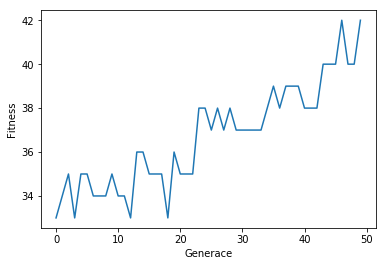

In [7]:
print('best fitness: ', onemax(best))
print('best: ', best)


%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(log)
plt.ylabel('Fitness')
plt.xlabel('Generace')

## Úkol na cvičení

Zkuste teď upravit algoritmus napsaný výše tak, aby řešil problém součtu podmnožiny, tj, nalezení takové podmnožiny, že její součet je přesně zadané číslo. V optimalizační verzi se tento problém snaží minimalizovat rozdíl mezi zadanou hodnotou a součtem podmnožiny.

Vstup si můžete vygenerovat náhodně.

In [8]:
mnozina = [random.randrange(0,50) + 100 for _ in range(100)] # 100 nahodnych cisel mezi 100 a 150
cislo = sum(mnozina)//2
print(cislo, mnozina)

6256 [127, 113, 132, 111, 130, 116, 102, 142, 138, 131, 125, 106, 109, 136, 107, 135, 122, 114, 110, 103, 144, 144, 134, 146, 114, 130, 136, 145, 117, 116, 120, 111, 142, 123, 122, 122, 137, 107, 118, 148, 102, 120, 129, 100, 149, 128, 139, 144, 112, 138, 149, 143, 101, 147, 116, 131, 129, 115, 112, 129, 107, 111, 131, 149, 136, 114, 127, 135, 137, 140, 125, 120, 144, 105, 104, 117, 127, 132, 113, 106, 144, 114, 116, 119, 142, 108, 138, 106, 109, 147, 149, 126, 146, 140, 101, 131, 126, 108, 103, 142]


## Knihovna deap 

Viděli jsme, že napsat vlatní evoluční algoritmus je snadné. Přesto se hodí používat některé knihovny, které nám práci usnadní. Jednou z oblíbených je knihovna `deap`. Nebudu tu kopírovat její tutoriál - [ten samý problém jako výše je v něm ale vyřešen][1].

  [1]: https://deap.readthedocs.io/en/master/examples/ga_onemax.html